# Panorama Image Stiching

Name: Anthony Kevin Oktavius

Library Import

In [3]:
!pip install opencv-contrib-python==4.4.0.44
!pip install opencv-python==4.4.0.44
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import imutils

Reading Image

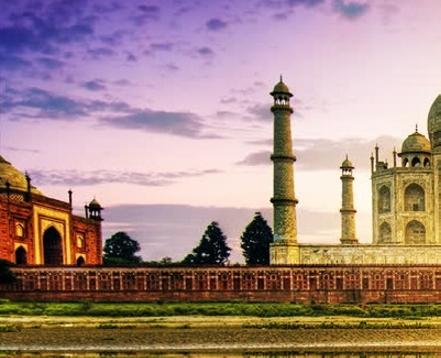

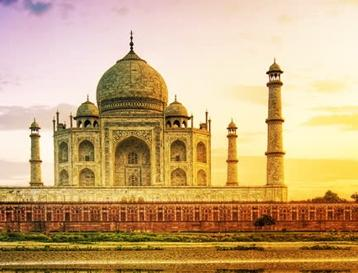

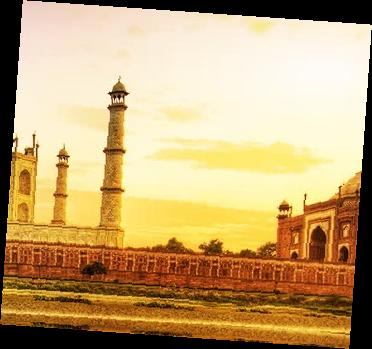

In [4]:
image_a = cv2.imread("1a.jpg")
image_b = cv2.imread("1b.jpg")
image_c = cv2.imread("1c.jpg")

cv2_imshow(image_a)
cv2_imshow(image_b)
cv2_imshow(image_c)

Preprocess Image

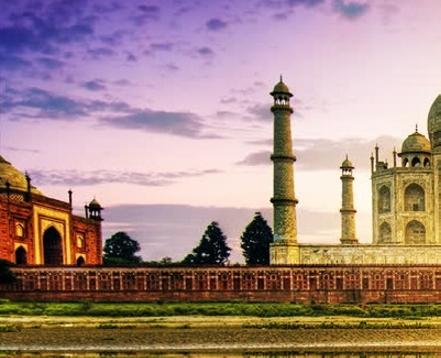

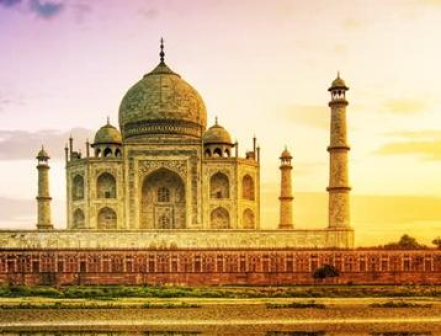

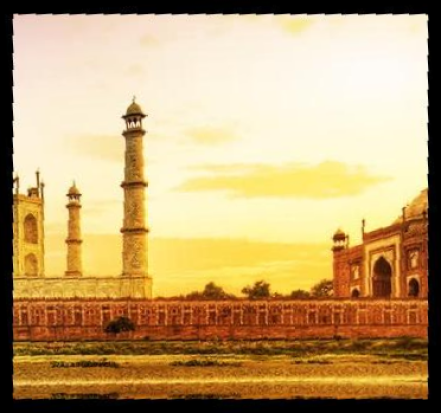

In [5]:
image_b = imutils.resize(image_b, width=441)
rotation = 30
image_c = imutils.rotate(image_c, 4)
image_c = imutils.resize(image_c, width=441)
cv2_imshow(image_a)
cv2_imshow(image_b)
cv2_imshow(image_c)

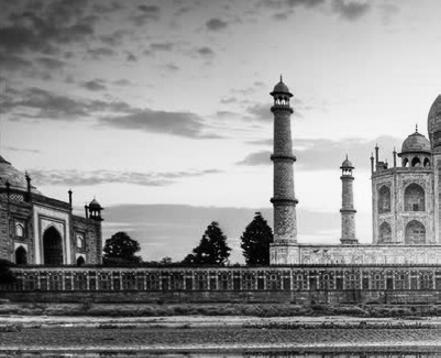

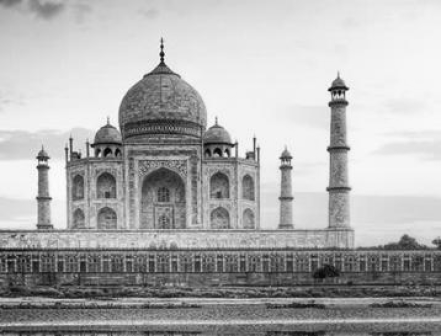

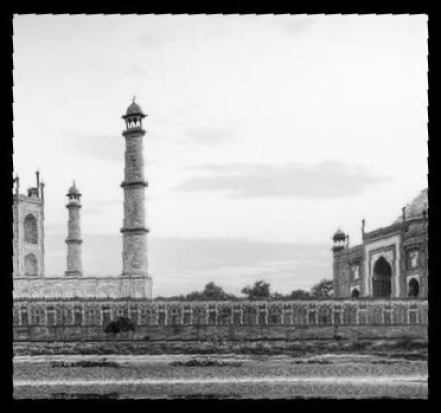

In [6]:
img1_gray = cv2.cvtColor(image_a, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(image_b, cv2.COLOR_BGR2GRAY)
img3_gray = cv2.cvtColor(image_c, cv2.COLOR_BGR2GRAY)

cv2_imshow(img1_gray)
cv2_imshow(img2_gray)
cv2_imshow(img3_gray)

Orb Create

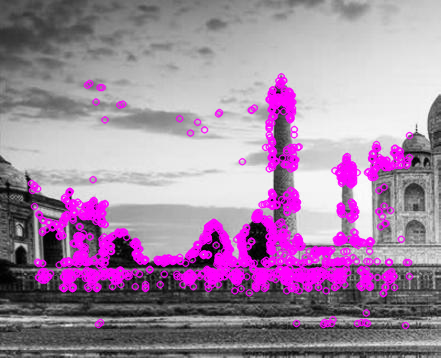

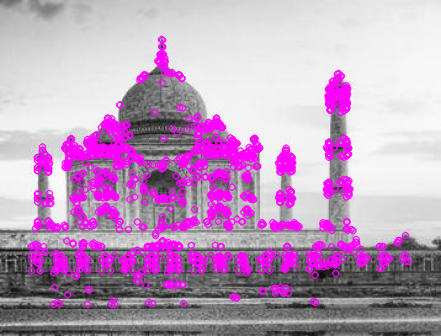

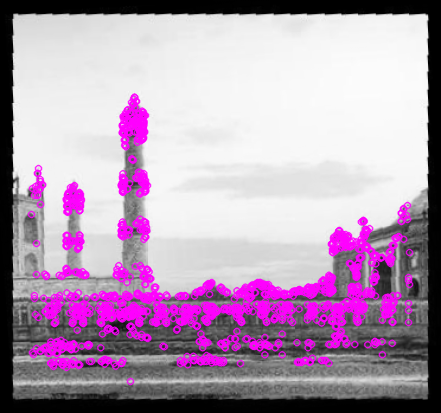

In [7]:
orb = cv2.ORB_create(nfeatures=2000)

keypoints1, descriptors1 = orb.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)
keypoints3, descriptors3 = orb.detectAndCompute(img3_gray, None)

cv2_imshow(cv2.drawKeypoints(img1_gray, keypoints1, None, (255, 0, 255)))
cv2_imshow(cv2.drawKeypoints(img2_gray, keypoints2, None, (255, 0, 255)))
cv2_imshow(cv2.drawKeypoints(img3_gray, keypoints3, None, (255, 0, 255)))

Create BF Matcher

In [8]:
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

matches_1 = bf.knnMatch(descriptors1, descriptors2,k=2)
matches_2 = bf.knnMatch(descriptors2, descriptors3,k=2)

Draw Matches Function

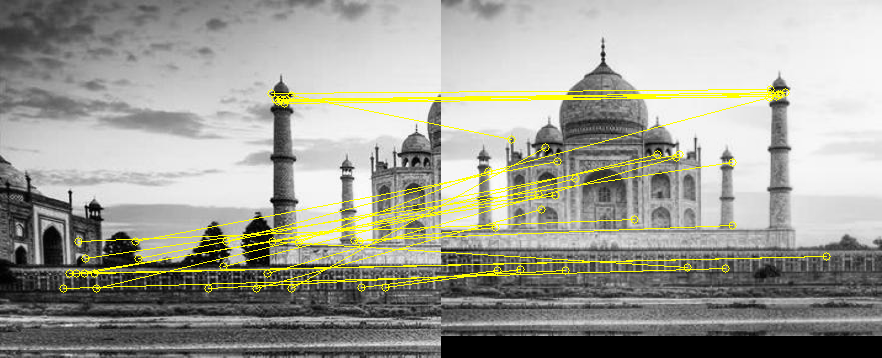

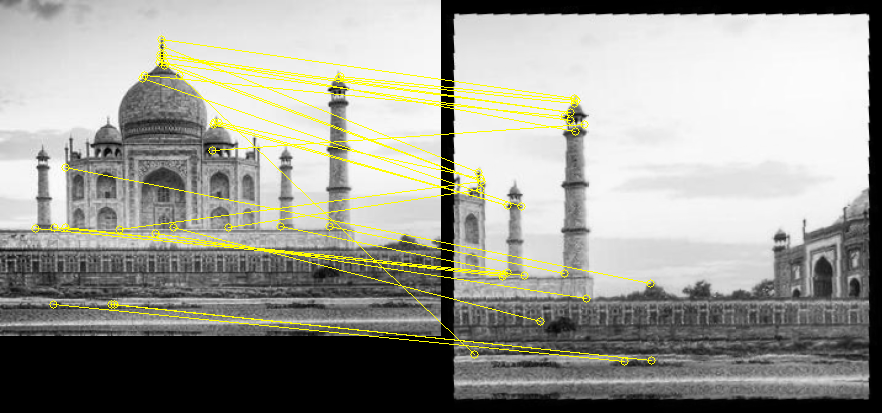

In [9]:
def draw_matches(img1, keypoints1, img2, keypoints2, matches):
  r, c = img1.shape[:2]
  r1, c1 = img2.shape[:2]

  output_img = np.zeros((max([r, r1]), c+c1, 3), dtype='uint8')
  output_img[:r, :c, :] = np.dstack([img1, img1, img1])
  output_img[:r1, c:c+c1, :] = np.dstack([img2, img2, img2])

  for match in matches:
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt

    cv2.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
    cv2.circle(output_img, (int(x2)+c,int(y2)), 4, (0, 255, 255), 1)

    cv2.line(output_img, (int(x1),int(y1)), (int(x2)+c,int(y2)), (0, 255, 255), 1)
    
  return output_img

all_matches = []
for m, n in matches_1:
  all_matches.append(m)

all_matches_2 = []
for m, n in matches_2:
  all_matches_2.append(m)

img3 = draw_matches(img1_gray, keypoints1, img2_gray, keypoints2, all_matches[:30])
img4 = draw_matches(img2_gray, keypoints2, img3_gray, keypoints3, all_matches_2[:30])
cv2_imshow(img3)
cv2_imshow(img4)

Keypoints

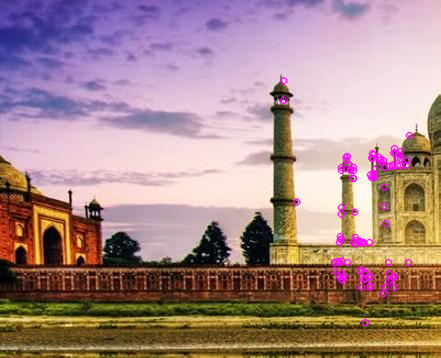

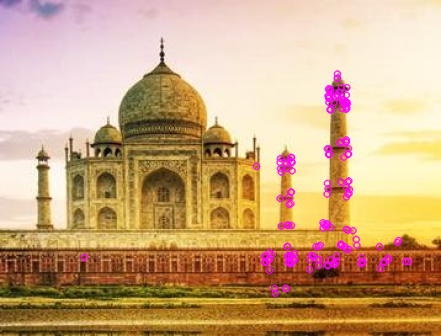

In [10]:
good = []
for m, n in matches_1:
    if m.distance < 0.6 * n.distance:
        good.append(m)

good_2 = []
for m, n in matches_2:
    if m.distance < 0.6 * n.distance:
        good_2.append(m)


cv2_imshow(cv2.drawKeypoints(image_a, [keypoints1[m.queryIdx] for m in good], None, (255, 0, 255)))
cv2_imshow(cv2.drawKeypoints(image_b, [keypoints2[m.queryIdx] for m in good_2], None, (255, 0, 255)))

Stiching Images Together

In [11]:
def warpImages(img1, img2, H):

  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

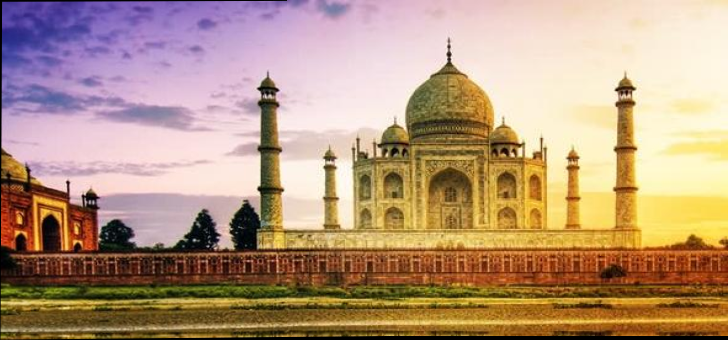

In [12]:
MIN_MATCH_COUNT = 10

if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    result = warpImages(image_b, image_a, M)

    cv2_imshow(result)
